# Performing Salary Predicting Using Machine Learning Algorithms: Hitters Dataset

## Business Problem

📌 Here we need to predict the salary of each baseball player. Click on this <a href="https://www.kaggle.com/datasets/floser/hitters">link</a> to review the data set and variables.

# Dataset Story

📌 This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
!pip install xgboost
from xgboost import XGBRegressor
!pip install lightgbm
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.4 MB/s eta 0:00:00


# Import Dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5000,N


# General Information About to the Dataset

In [3]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

######################### Head #########################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors   Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20      NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10 475.0000         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14 480.0000         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3 500.0000         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4  91.5000         N
######################### Tail 

# Analysis of Categorical and Numerical Variables

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  #Catgeorical Variable Selection
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category","object","bool"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8","int64","float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category","object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  #Numerical Variable Selection
  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8","int64","float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

In [6]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

#Print Categorical and Numerical Variables
print(f"Observations: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat_cols: {len(cat_cols)}")
print(f"Num_cols: {len(num_cols)}")
print(f"Cat_but_car: {len(cat_but_car)}")
print(f"num_but_cat: {len(num_but_cat)}")

Observations: 322
Variables: 20
Cat_cols: 3
Num_cols: 17
Cat_but_car: 0
num_but_cat: 0


In [7]:
def cat_summary(dataframe,col_name,plot=False):
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      'Ration': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
  print("##########################################")
  if plot:
    sns.countplot(x=dataframe[col_name],data=dataframe)
    plt.show(block=True)

In [8]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    cat_summary(dataframe, col, plot=True)

   League  Ration
A     175 54.3478
N     147 45.6522
##########################################


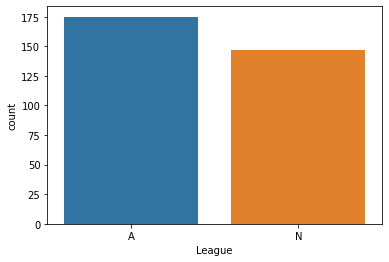

   Division  Ration
W       165 51.2422
E       157 48.7578
##########################################


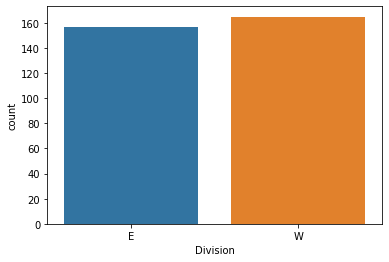

   NewLeague  Ration
A        176 54.6584
N        146 45.3416
##########################################


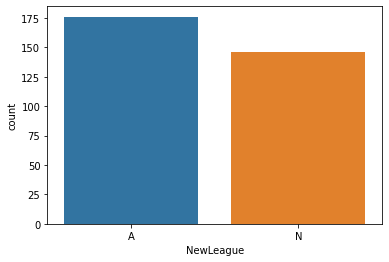

In [9]:
cat_summary_df(df)

In [10]:
def num_summary(dataframe, num_col, plot=False):
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.title(num_col)
    plt.show(block=True)

In [11]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

count   322.0000
mean    380.9286
std     153.4050
min      16.0000
1%       20.4200
5%      161.0000
10%     194.1000
20%     221.8000
30%     281.3000
40%     321.8000
50%     379.5000
60%     430.2000
70%     490.0000
80%     535.6000
90%     584.9000
95%     609.9000
99%     658.5900
max     687.0000
Name: AtBat, dtype: float64


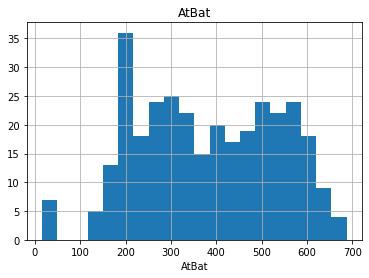

count   322.0000
mean    101.0248
std      46.4547
min       1.0000
1%        4.4200
5%       39.0000
10%      45.1000
20%      57.0000
30%      70.0000
40%      82.0000
50%      96.0000
60%     113.0000
70%     128.7000
80%     144.0000
90%     163.0000
95%     174.0000
99%     210.7900
max     238.0000
Name: Hits, dtype: float64


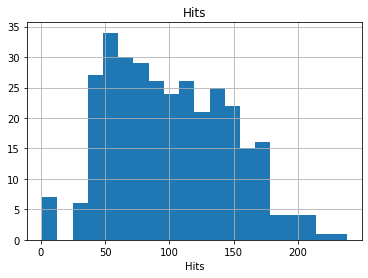

count   322.0000
mean     10.7702
std       8.7090
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       5.0000
40%       6.0000
50%       8.0000
60%      10.6000
70%      14.0000
80%      18.0000
90%      24.0000
95%      28.9500
99%      33.0000
max      40.0000
Name: HmRun, dtype: float64


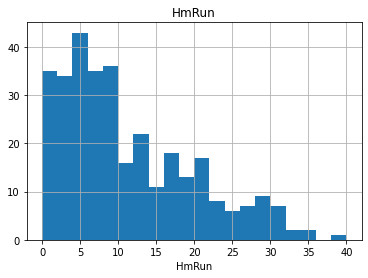

count   322.0000
mean     50.9099
std      26.0241
min       0.0000
1%        1.2100
5%       17.0000
10%      20.1000
20%      27.0000
30%      33.0000
40%      41.0000
50%      48.0000
60%      55.6000
70%      66.0000
80%      75.8000
90%      89.0000
95%      94.0000
99%     107.7900
max     130.0000
Name: Runs, dtype: float64


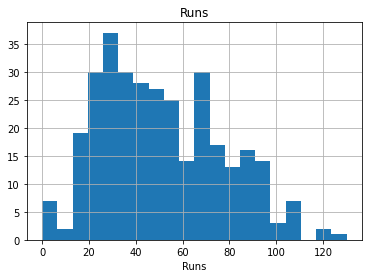

count   322.0000
mean     48.0280
std      26.1669
min       0.0000
1%        2.0000
5%       14.0000
10%      19.0000
20%      26.0000
30%      30.0000
40%      36.4000
50%      44.0000
60%      49.0000
70%      58.0000
80%      73.0000
90%      86.0000
95%      96.0000
99%     112.3700
max     121.0000
Name: RBI, dtype: float64


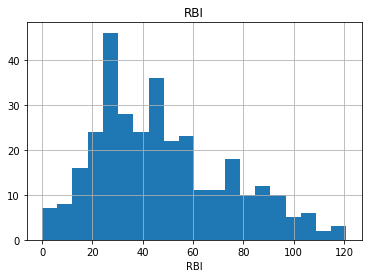

count   322.0000
mean     38.7422
std      21.6393
min       0.0000
1%        1.0000
5%       11.0500
10%      15.0000
20%      20.0000
30%      24.0000
40%      30.0000
50%      35.0000
60%      40.0000
70%      48.7000
80%      59.0000
90%      69.9000
95%      78.0000
99%      93.5800
max     105.0000
Name: Walks, dtype: float64


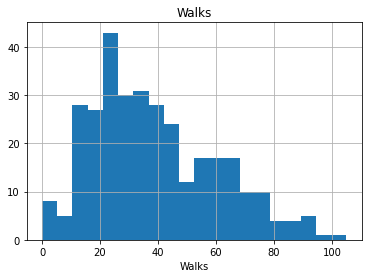

count   322.0000
mean      7.4441
std       4.9261
min       1.0000
1%        1.0000
5%        1.0000
10%       2.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       7.6000
70%      10.0000
80%      12.0000
90%      15.0000
95%      17.0000
99%      19.7900
max      24.0000
Name: Years, dtype: float64


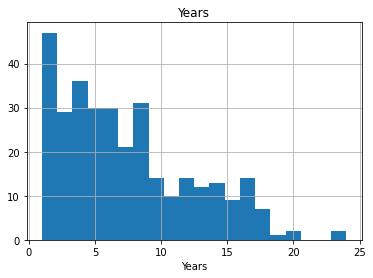

count     322.0000
mean     2648.6832
std      2324.2059
min        19.0000
1%         41.0000
5%        216.5000
10%       342.2000
20%       667.6000
30%       963.4000
40%      1402.2000
50%      1928.0000
60%      2654.0000
70%      3365.0000
80%      4483.0000
90%      6123.4000
95%      7125.6000
99%      8749.9700
max     14053.0000
Name: CAtBat, dtype: float64


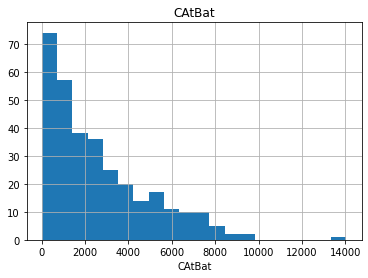

count    322.0000
mean     717.5714
std      654.4726
min        4.0000
1%         9.8400
5%        54.0000
10%       86.0000
20%      164.6000
30%      238.0000
40%      355.8000
50%      508.0000
60%      708.2000
70%      911.1000
80%     1229.2000
90%     1659.6000
95%     2017.1500
99%     2500.3400
max     4256.0000
Name: CHits, dtype: float64


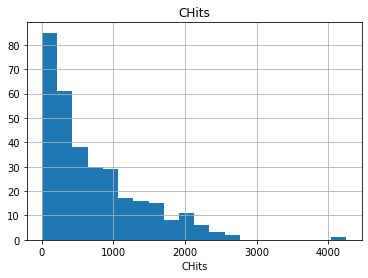

count   322.0000
mean     69.4907
std      86.2661
min       0.0000
1%        0.0000
5%        2.0000
10%       4.0000
20%      10.2000
30%      16.3000
40%      27.4000
50%      37.5000
60%      51.2000
70%      72.4000
80%     103.8000
90%     194.9000
95%     265.6500
99%     373.1200
max     548.0000
Name: CHmRun, dtype: float64


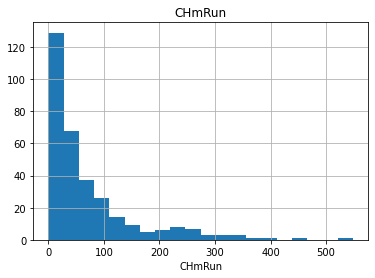

count    322.0000
mean     358.7950
std      334.1059
min        1.0000
1%         3.6300
5%        27.0000
10%       38.1000
20%       80.4000
30%      117.3000
40%      181.0000
50%      247.0000
60%      333.0000
70%      443.4000
80%      627.2000
90%      895.7000
95%     1032.3000
99%     1174.3700
max     2165.0000
Name: CRuns, dtype: float64


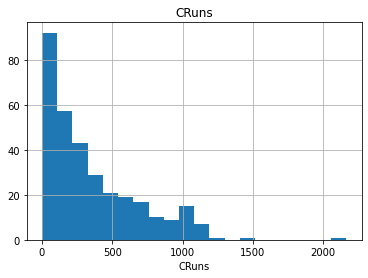

count    322.0000
mean     330.1180
std      333.2196
min        0.0000
1%         4.6300
5%        22.0500
10%       34.1000
20%       70.2000
30%      106.3000
40%      149.0000
50%      220.5000
60%      303.6000
70%      379.1000
80%      496.2000
90%      861.6000
95%     1071.7500
99%     1310.8500
max     1659.0000
Name: CRBI, dtype: float64


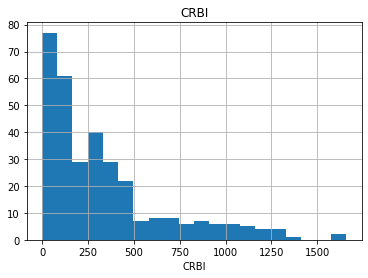

count    322.0000
mean     260.2391
std      267.0581
min        0.0000
1%         4.0000
5%        15.0500
10%       30.1000
20%       55.0000
30%       82.0000
40%      117.4000
50%      170.5000
60%      226.6000
70%      300.7000
80%      421.0000
90%      643.9000
95%      817.6000
99%     1139.1400
max     1566.0000
Name: CWalks, dtype: float64


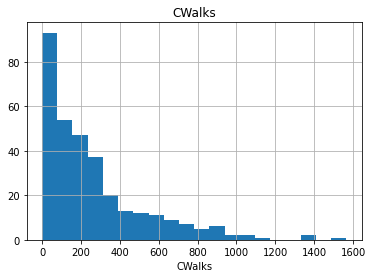

count    322.0000
mean     288.9379
std      280.7046
min        0.0000
1%         0.0000
5%        33.2000
10%       62.2000
20%       99.6000
30%      132.0000
40%      167.0000
50%      212.0000
60%      257.4000
70%      303.0000
80%      365.8000
90%      685.6000
95%      910.6500
99%     1301.1900
max     1378.0000
Name: PutOuts, dtype: float64


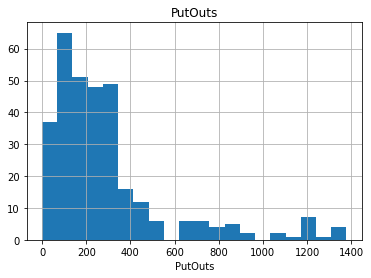

count   322.0000
mean    106.9130
std     136.8549
min       0.0000
1%        0.0000
5%        0.0000
10%       2.0000
20%       5.2000
30%       9.0000
40%      15.4000
50%      39.5000
60%      76.8000
70%     134.8000
80%     210.8000
90%     353.3000
95%     431.4500
99%     478.1600
max     492.0000
Name: Assists, dtype: float64


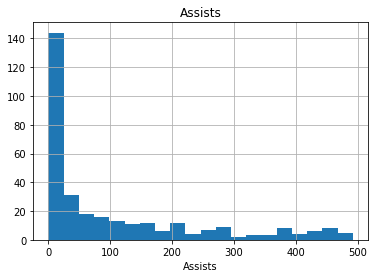

count   322.0000
mean      8.0404
std       6.3684
min       0.0000
1%        0.0000
5%        0.0000
10%       1.0000
20%       3.0000
30%       4.0000
40%       5.0000
50%       6.0000
60%       8.0000
70%      10.0000
80%      13.0000
90%      17.0000
95%      20.0000
99%      25.7900
max      32.0000
Name: Errors, dtype: float64


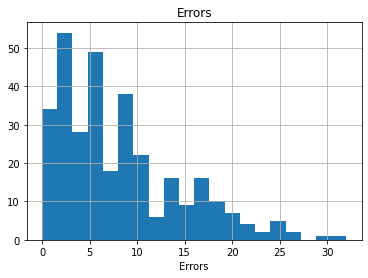

count    263.0000
mean     535.9259
std      451.1187
min       67.5000
1%        70.0000
5%        86.6000
10%      100.0000
20%      155.0000
30%      221.0000
40%      300.0000
50%      425.0000
60%      538.0000
70%      700.0000
80%      809.0000
90%     1048.6666
95%     1346.0000
99%     2032.8865
max     2460.0000
Name: Salary, dtype: float64


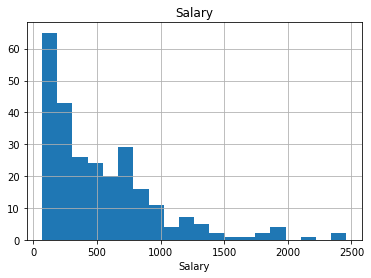

In [12]:
num_summary_df(df)

In [13]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  plt.figure(figsize=(16,16))
  for index, col in enumerate(num_cols):
    plt.subplot(6,3,index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

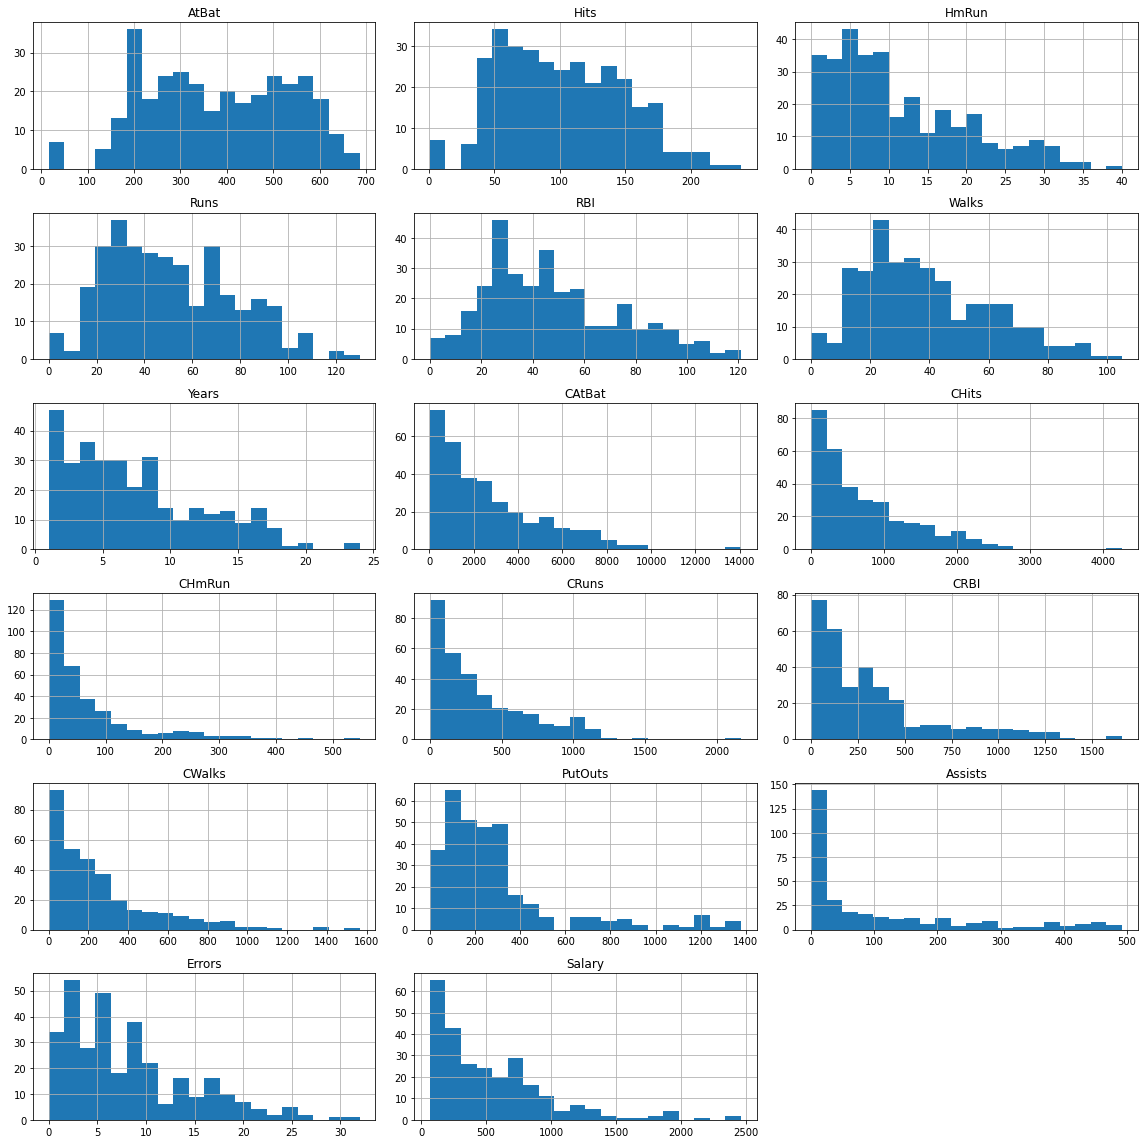

In [14]:
plot_num_summary(df)

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
  print(pd.DataFrame({"Target Mean": dataframe.groupby(categorical_col)[target].mean()}))
  print("#############################################")

In [16]:
def target_summary_with_cat_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
  for col in cat_cols:
    target_summary_with_cat(dataframe, target, col)

In [17]:
target_summary_with_cat_df(df, "Salary")

        Target Mean
League             
A          541.9995
N          529.1175
#############################################
          Target Mean
Division             
E            624.2714
W            450.8769
#############################################
           Target Mean
NewLeague             
A             537.1130
N             534.5539
#############################################


# Examination of the dependent variable

In [18]:
def exam_dependent_variable(dataframe, target):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  dataframe[target].hist(bins=100)
  plt.title(target + ", Histogram")
  plt.subplot(122)
  np.log1p(dataframe[target]).hist(bins=50)
  plt.title(target + ", Logaritmic Histogram")

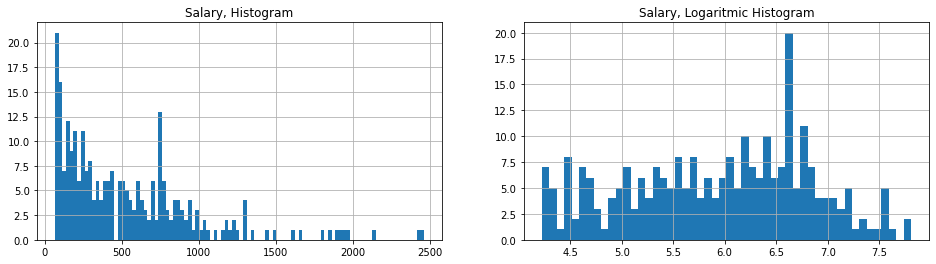

In [19]:
exam_dependent_variable(df, "Salary")

# Correlation Analysis

In [20]:
df.corr()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
AtBat,1.0000,0.9679,0.5922,0.9131,0.8205,0.6698,0.0474,0.2355,0.2527,0.2367,0.2665,0.2441,0.1661,0.3175,0.3538,0.3521,0.3948
Hits,0.9679,1.0000,0.5622,0.9222,0.8111,0.6412,0.0448,0.2276,0.2558,0.2027,0.2618,0.2320,0.1518,0.3107,0.3205,0.3100,0.4387
HmRun,0.5922,0.5622,1.0000,0.6510,0.8551,0.4810,0.1163,0.2219,0.2206,0.4932,0.2624,0.3520,0.2332,0.2829,-0.1063,0.0393,0.3430
Runs,0.9131,0.9222,0.6510,1.0000,0.7982,0.7322,0.0045,0.1865,0.2048,0.2279,0.2506,0.2060,0.1822,0.2793,0.2206,0.2405,0.4199
RBI,0.8205,0.8111,0.8551,0.7982,1.0000,0.6160,0.1462,0.2947,0.3082,0.4418,0.3233,0.3932,0.2509,0.3432,0.1066,0.1934,0.4495
Walks,0.6698,0.6412,0.4810,0.7322,0.6160,1.0000,0.1365,0.2772,0.2807,0.3325,0.3385,0.3086,0.4245,0.2995,0.1497,0.1294,0.4439
Years,0.0474,0.0448,0.1163,0.0045,0.1462,0.1365,1.0000,0.9203,0.9036,0.7269,0.8829,0.8688,0.8385,-0.0047,-0.0806,-0.1621,0.4007
CAtBat,0.2355,0.2276,0.2219,0.1865,0.2947,0.2772,0.9203,1.0000,0.9951,0.7988,0.9833,0.9492,0.9065,0.0623,0.0020,-0.0669,0.5261
CHits,0.2527,0.2558,0.2206,0.2048,0.3082,0.2807,0.9036,0.9951,1.0000,0.7833,0.9846,0.9451,0.8910,0.0765,-0.0025,-0.0628,0.5489
CHmRun,0.2367,0.2027,0.4932,0.2279,0.4418,0.3325,0.7269,0.7988,0.7833,1.0000,0.8202,0.9295,0.8000,0.1127,-0.1585,-0.1381,0.5249


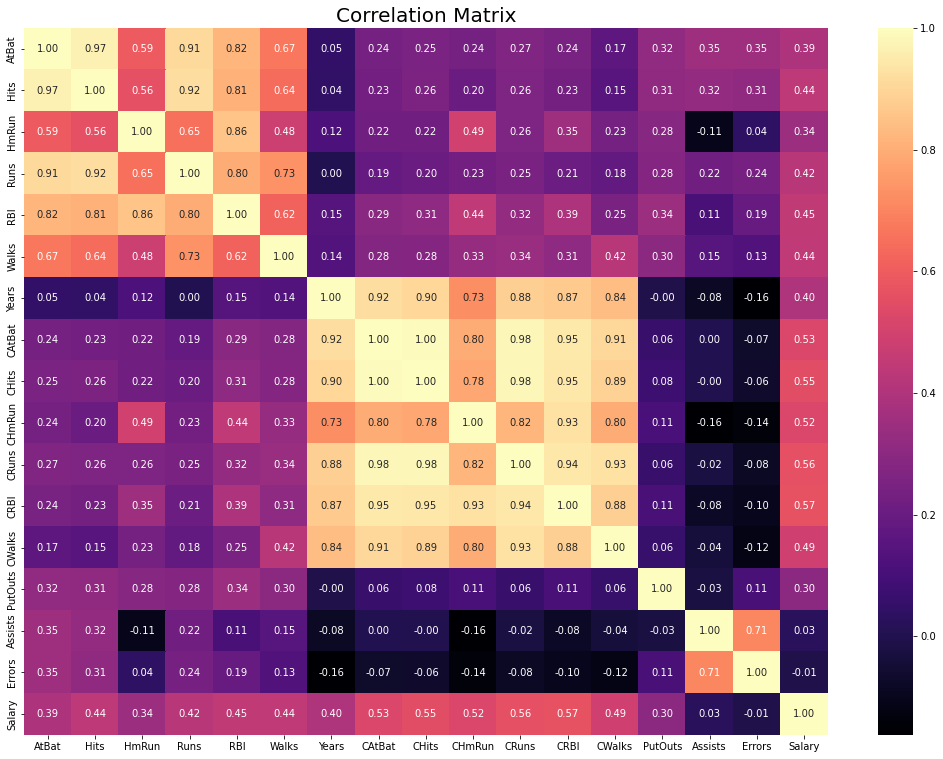

In [21]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [22]:
def high_correlated_cols(dataframe, plot=False, corr_th = 0.90):
  corr = dataframe.corr()
  corr_matrix = corr.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

  if drop_list == []:
    print("############## After Correlation Analysis, You Don't Need to Remove Variables ##############")

  if plot:
    sns.set(rc = {'figure.figsize':(18,13)})
    sns.heatmap(corr, cmap="RdBu")
    plt.show()
  return drop_list

<ipython-input-22-dcff60c12093>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


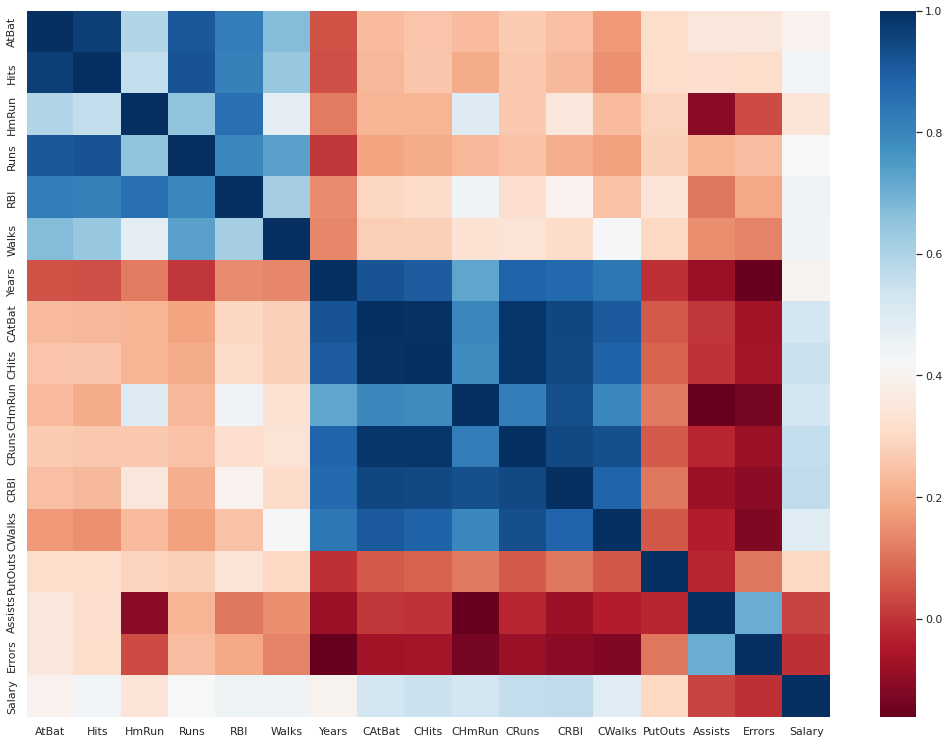

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

In [23]:
high_correlated_cols(df, plot=True)

# Exploratory Data Analysis

In [24]:
import scipy.stats as stats
def exploratory_data(dataframe):
  import warnings
  warnings.filterwarnings('ignore')
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  fig,ax = plt.subplots(len(num_cols),3,figsize=(20,90))
  # sns.set(font_scale=2)
  for index, col in enumerate(num_cols):
    sns.distplot(dataframe[col],ax=ax[index,0])
    sns.boxplot(dataframe[col],ax=ax[index,1])
    stats.probplot(dataframe[col],plot=ax[index,2])
  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Visualizing Continuous Columns")

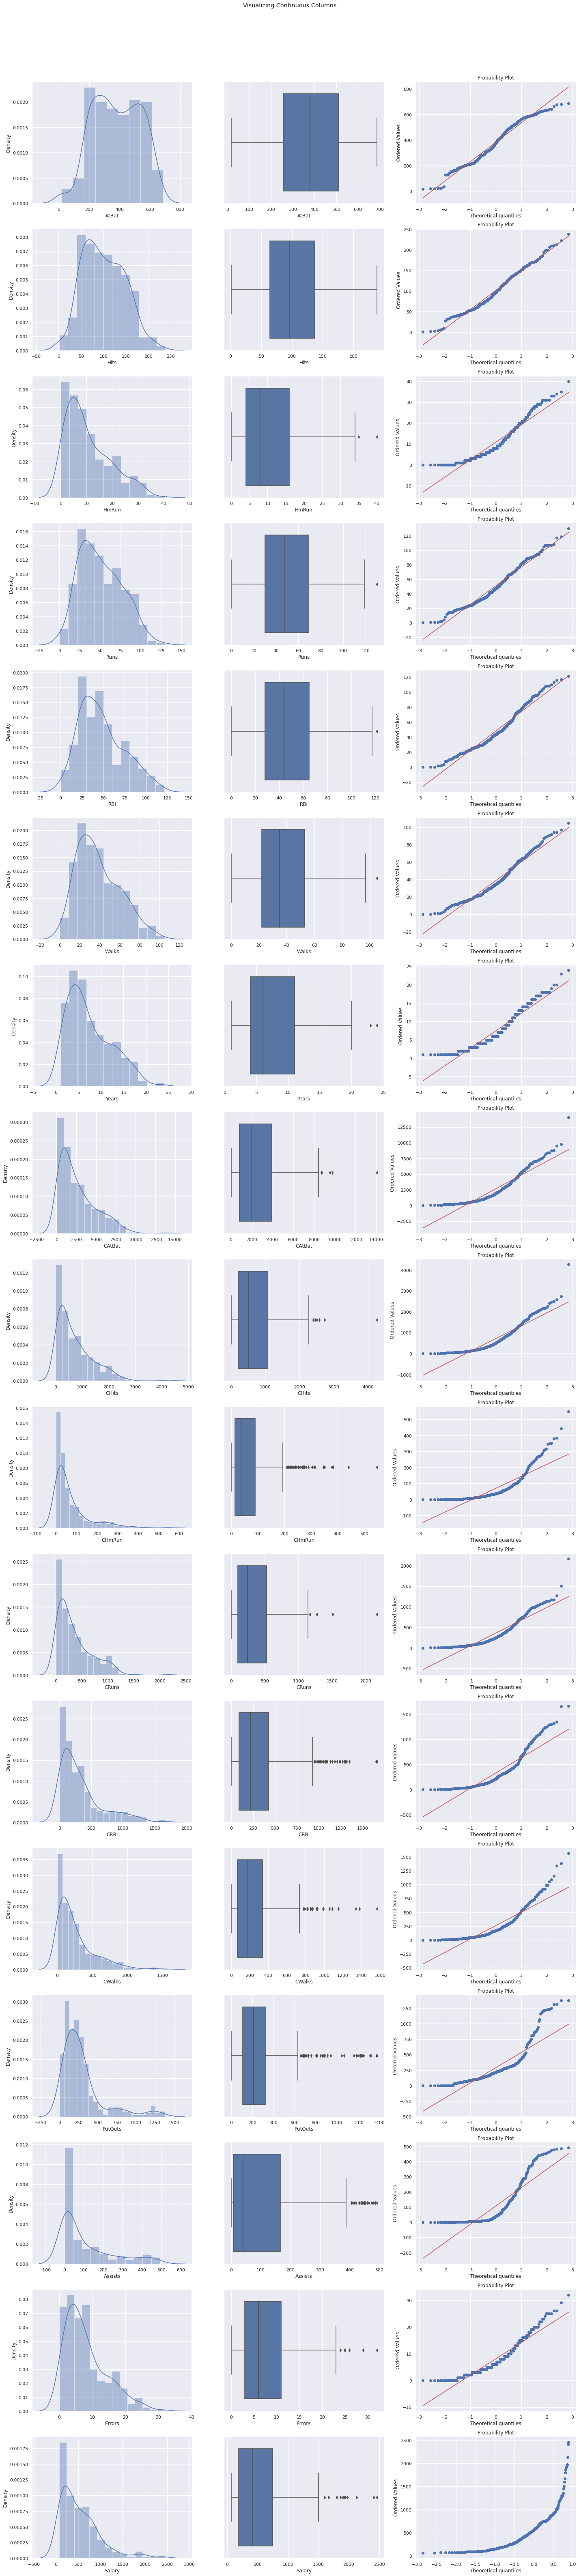

In [25]:
exploratory_data(df)

# Outlier Analysis

In [26]:
def outlier_thresholds(dataframe,col_name,q1=0.10,q3=0.90):
  quartile1 = dataframe[col_name].quantile(q1)
  quartile3 = dataframe[col_name].quantile(q3)
  interquartile_range = quartile3 - quartile1
  low_limit = quartile1 - 1.5 * interquartile_range
  up_limit = quartile3 + 1.5 * interquartile_range
  return low_limit,up_limit

In [27]:
def check_outlier(dataframe, col_name):
  low_limit,up_limit = outlier_thresholds(dataframe,col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [28]:
def replace_with_thresholds(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
  dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [29]:
def solve_outliers(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    if col!=target:
      print(col, check_outlier(dataframe, col))
      if check_outlier(dataframe, col):
        replace_with_thresholds(dataframe, col)

In [30]:
solve_outliers(df, "Salary")

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns False
CRBI False
CWalks True
PutOuts False
Assists False
Errors False


In [31]:
def check_outlier_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in num_cols:
    if col!=target:
      print(col, check_outlier(dataframe, col))

In [32]:
check_outlier_df(df, "Salary")

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False


# Missing Value Analysis

In [33]:
def missing_value_table(dataframe, na_name=False):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss","ratio"])
  print(missing_df, end="\n")
  if na_name:
    return na_columns

In [34]:
na_columns = missing_value_table(df, na_name=True)

        n_miss   ratio
Salary      59 18.3200


In [35]:
df["Salary"].fillna(df["Salary"].median(), inplace=True)

In [36]:
df.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

In [37]:
def rare_analyser(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  for col in cat_cols:
    print(col, ":", len(dataframe[col].value_counts()))
    print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                        "Ratio": dataframe[col].value_counts() / len(dataframe),
                        "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [38]:
rare_analyser(df, "Salary")

League : 2
   COUNT  Ratio  TARGET_MEAN
A    175 0.5435     517.9311
N    147 0.4565     512.8270


Division : 2
   COUNT  Ratio  TARGET_MEAN
E    157 0.4876     588.7325
W    165 0.5124     446.0152


NewLeague : 2
   COUNT  Ratio  TARGET_MEAN
A    176 0.5466     514.8178
N    146 0.4534     516.5450




In [39]:
def rare_encoder(dataframe, rare_prec):
  temp_df = dataframe.copy()
  rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes in ["category","object"]
                  and (temp_df[col].value_counts() / len(temp_df) < rare_prec).any(axis=None)]
  for var in rare_columns:
    tmp = temp_df[var].value_counts() / len(temp_df)
    rare_labels = tmp[tmp < rare_prec].index
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), "Rare", temp_df[var])
  return temp_df

In [40]:
new_df = rare_encoder(df, 0.01)

# Feature Extraction

In [41]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
new_num_cols=[col for col in num_cols if col!="Salary"]
df[new_num_cols]=df[new_num_cols]+0.0000000001
df['NEW_Hits'] = df['Hits'] / df['CHits'] + df['Hits']
df['NEW_RBI'] = df['RBI'] / df['CRBI']
df['NEW_Walks'] = df['Walks'] / df['CWalks']
df['NEW_PutOuts'] = df['PutOuts'] * df['Years']
df["Hits_Success"] = (df["Hits"] / df["AtBat"]) * 100
df["NEW_CRBI*CATBAT"] = df['CRBI'] * df['CAtBat']
df["NEW_RBI"] = df["RBI"] / df["CRBI"]
df["NEW_Chits"] = df["CHits"] / df["Years"]
df["NEW_CHmRun"] = df["CHmRun"] * df["Years"]
df["NEW_CRuns"] = df["CRuns"] / df["Years"]
df["NEW_Chits"] = df["CHits"] * df["Years"]
df["NEW_RW"] = df["RBI"] * df["Walks"]
df["NEW_RBWALK"] = df["RBI"] / df["Walks"]
df["NEW_CH_CB"] = df["CHits"] / df["CAtBat"]
df["NEW_CHm_CAT"] = df["CHmRun"] / df["CAtBat"]
df['NEW_Diff_Atbat'] = df['AtBat'] - (df['CAtBat'] / df['Years'])
df['NEW_Diff_Hits'] = df['Hits'] - (df['CHits'] / df['Years'])
df['NEW_Diff_HmRun'] = df['HmRun'] - (df['CHmRun'] / df['Years'])
df['NEW_Diff_Runs'] = df['Runs'] - (df['CRuns'] / df['Years'])
df['NEW_Diff_RBI'] = df['RBI'] - (df['CRBI'] / df['Years'])
df['NEW_Diff_Walks'] = df['Walks'] - (df['CWalks'] / df['Years'])

In [42]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks
0,293.0000,66.0000,1.0000,30.0000,29.0000,14.0000,1.0000,293.0000,66.0000,1.0000,30.0000,29.0000,14.0000,A,E,446.0000,33.0000,20.0000,425.0000,A,67.0000,1.0000,1.0000,446.0000,22.5256,8497.0000,66.0000,1.0000,30.0000,406.0000,2.0714,0.2253,0.0034,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,315.0000,81.0000,7.0000,24.0000,38.0000,39.0000,14.0000,3449.0000,835.0000,69.0000,321.0000,414.0000,375.0000,N,W,632.0000,43.0000,10.0000,475.0000,N,81.0970,0.0918,0.1040,8848.0000,25.7143,1427886.0000,11690.0000,966.0000,22.9286,1482.0000,0.9744,0.2421,0.0200,68.6429,21.3571,2.0714,1.0714,8.4286,12.2143
2,479.0000,130.0000,18.0000,66.0000,72.0000,76.0000,3.0000,1624.0000,457.0000,63.0000,224.0000,266.0000,263.0000,A,W,880.0000,82.0000,14.0000,480.0000,A,130.2845,0.2707,0.2890,2640.0000,27.1399,431984.0000,1371.0000,189.0000,74.6667,5472.0000,0.9474,0.2814,0.0388,-62.3333,-22.3333,-3.0000,-8.6667,-16.6667,-11.6667
3,496.0000,141.0000,20.0000,65.0000,78.0000,37.0000,11.0000,5628.0000,1575.0000,225.0000,828.0000,838.0000,354.0000,N,E,200.0000,11.0000,3.0000,500.0000,N,141.0895,0.0931,0.1045,2200.0000,28.4274,4716264.0000,17325.0000,2475.0000,75.2727,2886.0000,2.1081,0.2799,0.0400,-15.6364,-2.1818,-0.4545,-10.2727,1.8182,4.8182
4,321.0000,87.0000,10.0000,39.0000,42.0000,30.0000,2.0000,396.0000,101.0000,12.0000,48.0000,46.0000,33.0000,N,E,805.0000,40.0000,4.0000,91.5000,N,87.8614,0.9130,0.9091,1610.0000,27.1028,18216.0000,202.0000,24.0000,24.0000,1260.0000,1.4000,0.2551,0.0303,123.0000,36.5000,4.0000,15.0000,19.0000,13.5000


# Encoding Scaling

In [43]:
def label_encoding(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [44]:
def label_encoder(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and dataframe[col].nunique() == 2]
  for col in binary_cols:
      dataframe = label_encoding(dataframe, col)
  return dataframe

In [45]:
df = label_encoder(df)

In [46]:
def one_hot_encoder(dataframe, target, drop_first=False):
    binary_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O" and dataframe[col].nunique() == 2]
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)
    cat_cols = [col for col in cat_cols if col not in binary_cols and col not in [target]]
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

In [47]:
df = one_hot_encoder(df, "Salary", drop_first=True)

In [48]:
def apply_standardScaler(dataframe, target):  
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
  num_cols = [col for col in num_cols if col not in [target]]
  scaler = StandardScaler()
  dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])

In [49]:
apply_standardScaler(df, "Salary")

In [50]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NEW_Hits,NEW_RBI,NEW_Walks,NEW_PutOuts,Hits_Success,NEW_CRBI*CATBAT,NEW_Chits,NEW_CHmRun,NEW_CRuns,NEW_RW,NEW_RBWALK,NEW_CH_CB,NEW_CHm_CAT,NEW_Diff_Atbat,NEW_Diff_Hits,NEW_Diff_HmRun,NEW_Diff_Runs,NEW_Diff_RBI,NEW_Diff_Walks,League_1,Division_1,NewLeague_1
0,-0.5741,-0.7551,-1.1236,-0.8047,-0.7283,-1.1452,-1.3102,-1.0151,-1.0019,-0.8028,-0.9856,-0.9051,-0.9235,0.5604,-0.5409,1.8809,425.0000,-0.7409,2.2112,2.2814,-0.5811,-0.9558,-0.5812,-0.6892,-0.5669,-0.6323,-0.9006,0.8281,-1.4124,-1.3376,-0.4971,-0.4368,-0.5181,-0.4031,-0.5321,-0.5635,0,0,0
1,-0.4304,-0.4317,-0.4336,-1.0356,-0.3838,0.0119,1.3329,0.3449,0.1819,-0.0033,-0.1133,0.2521,0.4304,1.2240,-0.4677,0.3082,475.0000,-0.4368,-0.7919,-0.7612,2.2934,-0.0763,-0.0652,0.2923,0.1002,-0.9652,-0.3630,-0.5578,-0.7542,-0.2819,0.0969,0.2002,-0.1058,-0.3454,-0.0455,0.3089,1,1,1
2,0.6403,0.6247,0.8314,0.5808,0.9175,1.7244,-0.9036,-0.4416,-0.4000,-0.0739,-0.4041,-0.1927,0.0104,2.1089,-0.1823,0.9373,480.0000,0.6244,-0.2004,-0.1331,0.1695,0.3169,-0.4272,-0.5790,-0.4369,1.4699,1.6306,-0.5919,0.7817,0.9135,-1.0365,-1.1029,-1.1153,-0.8706,-1.4942,-1.3968,0,1,0
3,0.7513,0.8619,1.0614,0.5423,1.1472,-0.0806,0.7230,1.2839,1.3210,1.8308,1.4065,1.5265,0.3517,-0.3173,-0.7019,-0.7927,500.0000,0.8575,-0.7876,-0.7595,0.0190,0.6721,1.1302,0.7681,1.1433,1.4985,0.3385,0.8744,0.7210,0.9889,-0.6324,-0.5018,-0.6086,-0.9572,-0.4271,-0.2194,1,0,1
4,-0.3913,-0.3024,-0.0886,-0.4584,-0.2307,-0.4046,-1.1069,-0.9707,-0.9480,-0.6735,-0.9317,-0.8540,-0.8523,1.8413,-0.4897,-0.6354,91.5000,-0.2908,1.9237,1.9727,-0.1828,0.3067,-0.5776,-0.6777,-0.5510,-0.9147,-0.4739,-0.0201,-0.2481,0.3733,0.5673,0.6519,0.2781,0.4059,0.5648,0.4007,1,0,1


# Create a Base Model

In [84]:
def create_base_model(dataframe, target, plot=False, save_results=False):
  names = []
  train_rmse_results = []
  test_rmse_results = []
  train_r2_scores = []
  test_r2_scores = []
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)
  models = [('LR', LinearRegression()),
            ("Ridge", Ridge()),
            ("Lasso", Lasso()),
            ("ElasticNet", ElasticNet()),
            ('SVR', SVR()),
            ('KNN', KNeighborsRegressor()),
            ('CART', DecisionTreeRegressor()),
            ('RF', RandomForestRegressor()),
            ("AdaBoost", AdaBoostRegressor()),
            ('BGTrees', BaggingRegressor(bootstrap_features=True)),
            ('GBM', GradientBoostingRegressor()),
            ("XGBoost", XGBRegressor(objective='reg:squarederror')),
            ("LightGBM", LGBMRegressor()),
            ("CatBoost", CatBoostRegressor(verbose=False))]
  print("###################### Mean and Std(Target Variable) ######################")
  print("Mean: " , dataframe[target].mean())
  print("Std: ", dataframe[target].std())
  print("###################### Model Results ######################")

  for name, regressor in models:
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    # RMSE
    train_rmse_result = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse_result = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_rmse_results.append(train_rmse_result)
    test_rmse_results.append(test_rmse_result)
    # score
    train_r2_score = regressor.score(X_train, y_train)
    test_r2_score = regressor.score(X_test, y_test)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)
    # Model names
    names.append(name)
  
  model_results = pd.DataFrame({'Model_Names': names,
                                'RMSE_Train': train_rmse_results,
                                'RMSE_Test': test_rmse_results,
                                'R2_score_Train': train_r2_scores,
                                'R2_score_Test': test_r2_scores
                                }).set_index("Model_Names")
  model_results=model_results.sort_values(by="RMSE_Test", ascending=True)
  print(model_results)

  if plot:
    plt.figure(figsize=(15, 12))
    sns.barplot(x='RMSE_Test', y=model_results.index, data=model_results, color="r")
    plt.xlabel('RMSE Values')
    plt.ylabel('Model Names')
    plt.title('RMSE_Test for All Models')
    plt.show()
  
  if save_results:
    model_results.to_csv("model_results.csv")
  
  return model_results

###################### Mean and Std(Target Variable) ######################
Mean:  515.600953416149
Std:  409.8174589416264
###################### Model Results ######################
             RMSE_Train  RMSE_Test  R2_score_Train  R2_score_Test
Model_Names                                                      
LR             220.9678   280.1825          0.6439         0.7243
Ridge          225.6116   287.9779          0.6288         0.7087
Lasso          225.4010   289.9113          0.6295         0.7048
XGBoost         77.8775   294.9000          0.9558         0.6945
GBM             65.0487   296.0704          0.9691         0.6921
RF             100.0564   314.3346          0.9270         0.6529
LightGBM       101.4236   324.3217          0.9250         0.6305
BGTrees        118.1107   339.9517          0.8983         0.5941
CART             0.0000   352.3365          1.0000         0.5639
AdaBoost       180.0252   367.1674          0.7636         0.5265
CatBoost        12.0299 

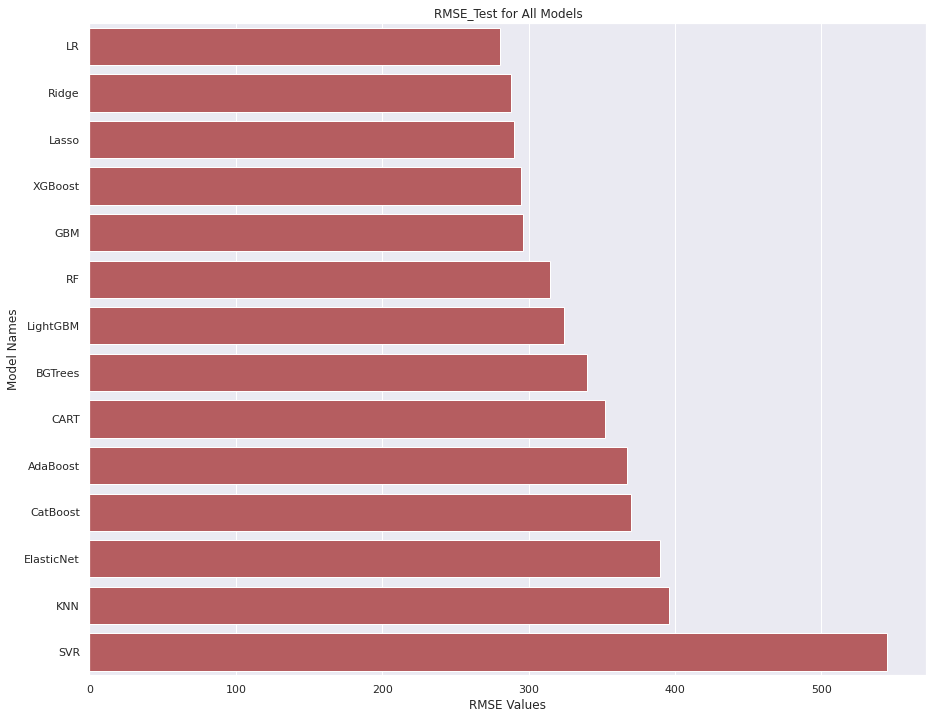

In [85]:
model_results = create_base_model(df, "Salary", plot=True, save_results=True)

In [87]:
def create_model_tuned(dataframe, target, plot=True, save_results=True):
  names = []
  train_rmse_results = []
  test_rmse_results = []
  train_r2_scores = []
  test_r2_scores = []
  best_params = []

  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

  ridge_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  lasso_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  enet_params = {"alpha": 10**np.linspace(10,-2,100)*0.5}

  svr_params = {"C": np.arange(0.1,1,0.1)}

  knn_params = {"n_neighbors": np.arange(1,50,1)}

  cart_params = {"min_samples_split": range(2,100),
                  "max_leaf_nodes": range(2,10)}

  adaboost_params = {"learning_rate": [0.01, 0.1],
                            "loss": ["linear", "square", "exponential"],
                            "n_estimators": [100, 500, 1000]}

  xgboost_params = {"colsample_bytree": [0.4, 0.5 ,0.6],
                      "n_estimators": [200, 500, 1000],
                      "max_depth": [3,5,8],
                      "learning_rate": [0.1, 0.01]}

  rf_params = {"max_depth": [5, 8, 15, None],
              "max_features": [5, 7, "auto"],
              "min_samples_split": [8, 15, 20],
              "n_estimators": [200, 500]}

  gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

  lightgbm_params = {"learning_rate": [0.01, 0.1],
                    "n_estimators": [300, 500],
                    "colsample_bytree": [0.7, 1]}

  catboost_params = {"iterations": [200, 500],
                    "learning_rate": [0.01, 0.1],
                    "depth": [3, 6]}
  regressors = [("Ridge", Ridge(), ridge_params),
              ("Lasso", Lasso(), lasso_params),
              ("ENet", ElasticNet(), enet_params),
              ("SVR", SVR(), svr_params),
              ("KNN", KNeighborsRegressor(), knn_params),
              ("CART", DecisionTreeRegressor(), cart_params),
              ("AdaBoost", AdaBoostRegressor(), adaboost_params),
              ("XGBoost", XGBRegressor(objective="reg:squarederror"), xgboost_params),
              ("RF", RandomForestRegressor(), rf_params),
              ('GBM', GradientBoostingRegressor(), gbm_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params),
              ("CatBoost", CatBoostRegressor(verbose=False), catboost_params)]

  for name, regressor, params in regressors:
    print(f"#################### {name} ####################")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X_train, y_train)

    final_model = regressor.set_params(**gs_best.best_params_).fit(X_train, y_train)
    train_rmse_result = np.mean(np.sqrt(-cross_val_score(final_model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    test_rmse_result = np.mean(np.sqrt(-cross_val_score(final_model, X_test, y_test, cv=10, scoring="neg_mean_squared_error")))
    train_rmse_results.append(train_rmse_result)
    test_rmse_results.append(test_rmse_result)
    train_r2_score = final_model.score(X_train, y_train)
    test_r2_score = final_model.score(X_test, y_test)
    train_r2_scores.append(train_r2_score)
    test_r2_scores.append(test_r2_score)
    print(f"RMSE_Train: {round(train_rmse_result, 4)} , RMSE_Test: {round(test_rmse_result, 4)} , R2_Train: {round(train_r2_score, 3)} , R2_Test: {round(test_r2_score, 3)} (Tuned Model) ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
    best_params.append(gs_best.best_params_)
    names.append(name)
  
  model_tuned_results = pd.DataFrame({'Model_Names': names,
                                'RMSE_Train': train_rmse_results,
                                'RMSE_Test': test_rmse_results,
                                'R2_score_Train': train_r2_scores,
                                'R2_score_Test': test_r2_scores,
                                "best_params": best_params
                                }).set_index("Model_Names")
  model_tuned_results=model_tuned_results.sort_values(by="RMSE_Test", ascending=True)
  print(model_tuned_results)

  if plot:
    plt.figure(figsize=(15, 12))
    sns.barplot(x='RMSE_Test', y=model_tuned_results.index, data=model_tuned_results, color="r")
    plt.xlabel('RMSE Values')
    plt.ylabel('Model Names')
    plt.title('RMSE_Test for All Models')
    plt.show()
  
  if save_results:
    model_tuned_results.to_csv("model_tuned_results.csv")
  
  return model_tuned_results

#################### Ridge ####################
RMSE_Train: 268.08 , RMSE_Test: 342.6275 , R2_Train: 0.616 , R2_Test: 0.678 (Tuned Model) (Ridge) 
Ridge best params: {'alpha': 3.0679536367065814}

#################### Lasso ####################
RMSE_Train: 277.3081 , RMSE_Test: 341.8522 , R2_Train: 0.617 , R2_Test: 0.68 (Tuned Model) (Lasso) 
Lasso best params: {'alpha': 1.7555958671075638}

#################### ENet ####################
RMSE_Train: 268.2691 , RMSE_Test: 345.1895 , R2_Train: 0.608 , R2_Test: 0.66 (Tuned Model) (ENet) 
ENet best params: {'alpha': 0.03527401155359316}

#################### SVR ####################
RMSE_Train: 363.1589 , RMSE_Test: 498.6309 , R2_Train: -0.018 , R2_Test: -0.044 (Tuned Model) (SVR) 
SVR best params: {'C': 0.9}

#################### KNN ####################
RMSE_Train: 287.007 , RMSE_Test: 334.5576 , R2_Train: 0.461 , R2_Test: 0.457 (Tuned Model) (KNN) 
KNN best params: {'n_neighbors': 14}

#################### CART ####################
RMSE

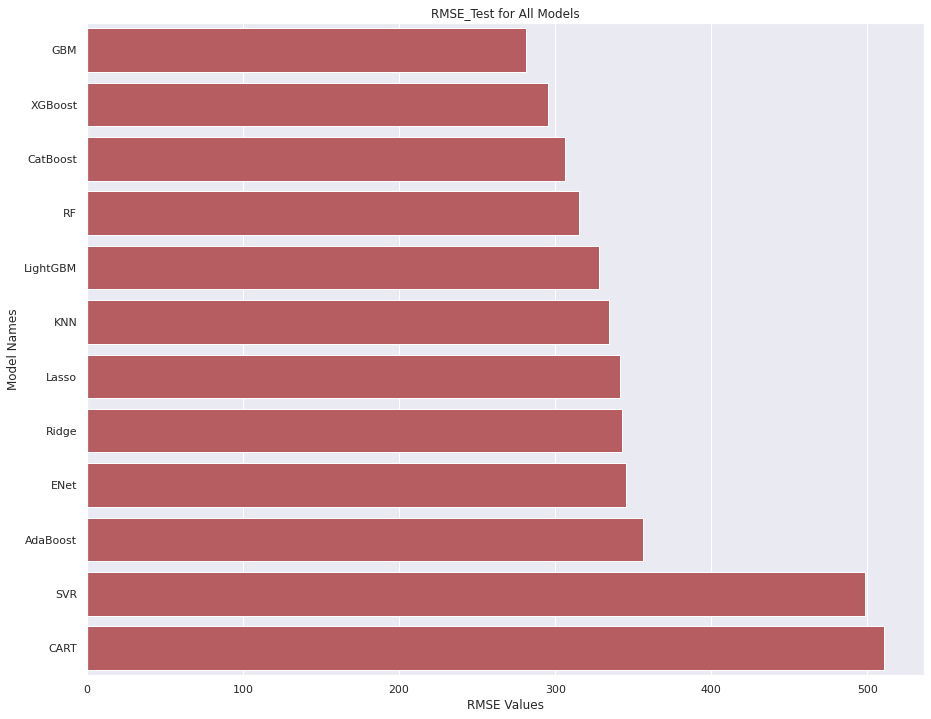

In [88]:
model_tuned_results = create_model_tuned(df, "Salary", plot=True, save_results=True)